In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torchvision.transforms import Compose
from data import COLUMNS
from plotly import graph_objects as go
from transform import ExtractAtomicNumber, ExtractCoordinates, MonomerGraph, DimerGraph
from dataset import DimerDataset
from model import DimerInteractionEnergyModel
from tqdm import tqdm
from matplotlib import pyplot as plt

/home/sanghyeonl/miniforge3/envs/torch/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`.",
)

In [3]:
def MonomerGraphObject(data):
    _color = ["#0000FF", "#FF0000"]
    fig = go.Figure()

    for p in data["pos"]:
        fig.add_trace(
            go.Scatter3d(
                x=p[:, 0],
                y=p[:, 1],
                z=p[:, 2],
                mode="markers",
                marker=dict(size=3),
            )
        )

    for i, (p, graph) in enumerate(zip(data["pos"], data["mgraph"])):
        for s, d in zip(graph["src"], graph["dst"]):
            fig.add_trace(
                go.Scatter3d(
                    x=[p[s, 0], p[d, 0]],
                    y=[p[s, 1], p[d, 1]],
                    z=[p[s, 2], p[d, 2]],
                    mode="lines",
                    line=dict(color=_color[i]),
                )
            )

    return fig


def DimerGraphObject(data):
    _color = "#00FF00"
    fig = MonomerGraphObject(data)

    for s, d in zip(data["dgraph"]["src"], data["dgraph"]["dst"]):
        fig.add_trace(
            go.Scatter3d(
                x=[data["pos"][0][s, 0], data["pos"][1][d, 0]],
                y=[data["pos"][0][s, 1], data["pos"][1][d, 1]],
                z=[data["pos"][0][s, 2], data["pos"][1][d, 2]],
                mode="lines",
                line=dict(color=_color),
            )
        )

    return fig

In [4]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [5]:
file_name = "DES15K.csv"
file_path = os.path.join("data", file_name)
transform = Compose(
    [
        ExtractAtomicNumber(),
        ExtractCoordinates(),
        MonomerGraph(r_cut=2.0, n_neighbors=0),
        DimerGraph(r_cut=10.0, n_neighbors=0),
    ]
)
dataset = DimerDataset(file_path, COLUMNS.DTYPES, transform=transform)

In [6]:
model = DimerInteractionEnergyModel(
    device=device,
    activation_fn=torch.tanh,
    max_z=118,
    dim_atoms=30,
    mu_min=0.0,
    mu_max=20.0,
    step=0.2,
    irreps_r="101x0e",
    irreps_sh="1x0e+1x1o+1x2e",
    irreps_atom="30x0e",
    n_interactions=3,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

In [7]:
train_dataset = dataset[:1000]
valid_dataset = dataset[1000:1200]
infer_dataset = dataset[-1000:]

In [8]:
best_loss = torch.inf

train_loss = []
threshold = 3
count = 0

for epoch in range(100):
    model.train()
    _loss = []
    for batch in tqdm(train_dataset, desc=f"Epoch #{epoch + 1:02} (train)"):
        data, readout = model(batch)
        loss = (data["cc_HF"] - readout) ** 2
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _loss.append(loss.item())
    _loss = np.mean(_loss)
    train_loss.append(_loss)

    model.eval()
    valid_loss = []
    with torch.no_grad():
        for batch in tqdm(valid_dataset, desc=f"Epoch #{epoch + 1:02} (valid)"):
            data, readout = model(batch)
            loss = (data["cc_HF"] - readout) ** 2
            valid_loss.append(loss.item())
        valid_loss = np.mean(valid_loss)
        if valid_loss < best_loss:
            count = 0
            best_loss = valid_loss
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": best_loss,
                },
                "model.pt",
            )
        else:
            count += 1
            if count > threshold:
                break

Epoch #85 (valid): 100%|██████████| 200/200 [00:00<00:00, 284.67it/s]


In [9]:
checkpoint = torch.load("model.pt")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [14]:
model.eval()
label = []
inference = []
with torch.no_grad():
    for batch in infer_dataset:
        data, readout = model(batch)
        label.append(data["cc_HF"])
        inference.append(readout.item())

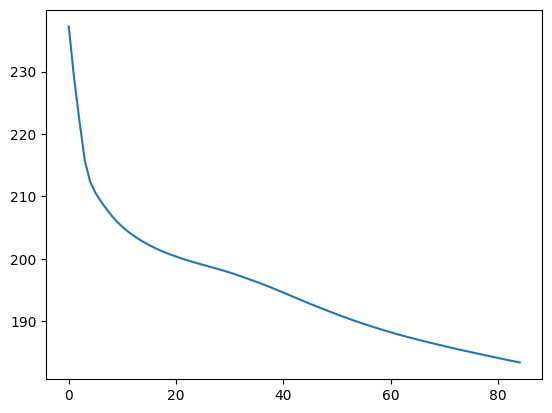

In [12]:
plt.plot(train_loss)
plt.show()

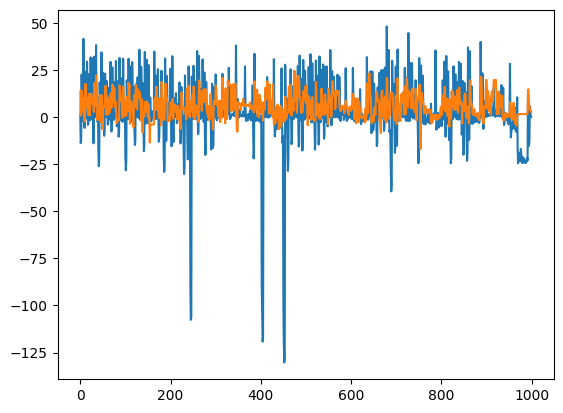

In [15]:
plt.plot(label, label="label")
plt.plot(inference, label="model")
plt.show()

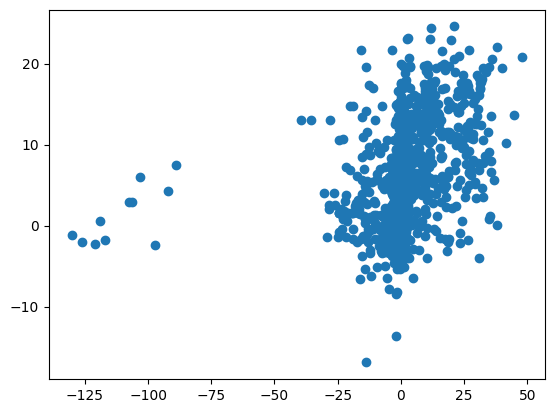

In [21]:
plt.scatter(label, inference)
plt.show()

In [28]:
# TODO n_neighbor is functioning wrong in DimerGraph
idx = np.random.randint(len(infer_dataset))
data = infer_dataset[idx]
DimerGraphObject(data).show()